In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils import resample

In [2]:
df=pd.read_csv('creditcardfraud_normalised.csv')
df['class'].value_counts()

class
0    284315
1       492
Name: count, dtype: int64

# Unified Sampling Theory (UST) 

In [4]:
def unified_sampling(dataframe,minority_ratio=0.5):
    df1=dataframe[dataframe['class']==0]
    df2=dataframe[dataframe['class']==1]
    total_samples_needed = int((len(df2) / minority_ratio) * 2)
    minority_samples_needed = int(total_samples_needed * minority_ratio)
    majority_samples_needed = total_samples_needed - minority_samples_needed
    data_minority_resampled = resample(df2, replace=True, n_samples=minority_samples_needed, random_state=42)
    if majority_samples_needed > len(df1):
        raise ValueError("Desired majority sample size exceeds the actual majority class size. Please adjust the desired_minority_ratio.")
    else:
        data_majority_resampled = resample(df1, replace=False, 
                                            n_samples=majority_samples_needed, 
                                            random_state=42)
    data_resampled = pd.concat([data_minority_resampled, data_majority_resampled], axis=0)
    return data_resampled
data=unified_sampling(df)


In [5]:
data2=data.drop(columns=['class'])

### calculating Euclidean norm (L2 norm)
#### percentile-based thresholding with l2 norm

In [6]:

norms = np.linalg.norm(data2, axis=1)
data['l2norm']=norms
percentile_threshold = np.percentile(norms, 75)
thresholded_points = data[norms > percentile_threshold]
y_true = data['class']
y_pred = np.where(norms > percentile_threshold, 1, 0)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.58      0.47       984
           1       0.17      0.08      0.11       984

    accuracy                           0.33      1968
   macro avg       0.28      0.33      0.29      1968
weighted avg       0.28      0.33      0.29      1968



### Manhattan norm (L1 norm)
#### percentile-based thresholding with l1 norm

In [7]:
# Calculate L1 norm for each point
norms1 = np.linalg.norm(data2.values, ord=1, axis=1)

# Add L1 norm as a new column to the DataFrame
data['L1_norm'] = norms1

percentile_threshold = np.percentile(norms1, 75)
thresholded_points = data[norms1 > percentile_threshold]
y_true = data['class']
y_pred = np.where(norms1 > percentile_threshold, 1, 0)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.58      0.47       984
           1       0.17      0.08      0.11       984

    accuracy                           0.33      1968
   macro avg       0.28      0.33      0.29      1968
weighted avg       0.28      0.33      0.29      1968



### maximum norm (L∞ norm) 
### percentile-based thresholding with (L∞ norm) 

In [8]:
# Calculate L∞ norm for each point
norms3 = np.max(np.abs(data2.values), axis=1)

# Add L∞ norm as a new column to the DataFrame
data['L∞_norm'] = norms3

percentile_threshold = np.percentile(norms3, 75)
thresholded_points = data[norms3 > percentile_threshold]
y_true = data['class']
y_pred = np.where(norms3 > percentile_threshold, 1, 0)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.61      0.49       984
           1       0.23      0.11      0.15       984

    accuracy                           0.36      1968
   macro avg       0.32      0.36      0.32      1968
weighted avg       0.32      0.36      0.32      1968



### Mahalanobis distance
#### percentile-based thresholding with  Mahalanobis distances 

In [9]:
# Calculate covariance matrix from data values
cov_matrix = np.cov(data2.values, rowvar=False)

# Inverse of covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate Mahalanobis distance for each point
# Mean vector
mean_vector = data2.mean().values  # Convert mean vector to numpy array

# Calculate Mahalanobis distance for each point
mahalanobis_distances = []
for idx, point in data2.iterrows():
    diff = point.values - mean_vector
    mahalanobis_distance = np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff))
    mahalanobis_distances.append(mahalanobis_distance)

# Add Mahalanobis distance as a new column to the DataFrame
data['Mahalanobis_distance'] = mahalanobis_distances

percentile_threshold = np.percentile(mahalanobis_distances, 75)
thresholded_points = data[mahalanobis_distances > percentile_threshold]
y_true = data['class']
y_pred = np.where(mahalanobis_distances > percentile_threshold, 1, 0)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.84      0.67       984
           1       0.67      0.34      0.45       984

    accuracy                           0.59      1968
   macro avg       0.62      0.59      0.56      1968
weighted avg       0.62      0.59      0.56      1968



### Thresholding using z-score

In [10]:
mean = data2.mean()
std = data2.std()
standardized_data = (data2 - mean) / std
y_true = data['class']
y_pred = np.where((standardized_data.abs() > 2).any(axis=1), 1, 0)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68       984
           1       0.68      0.56      0.62       984

    accuracy                           0.65      1968
   macro avg       0.65      0.65      0.65      1968
weighted avg       0.65      0.65      0.65      1968



### Area under AUC-ROC Curve

In [11]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_true, y_pred)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.6498983739837398


#### correlation Heatmap

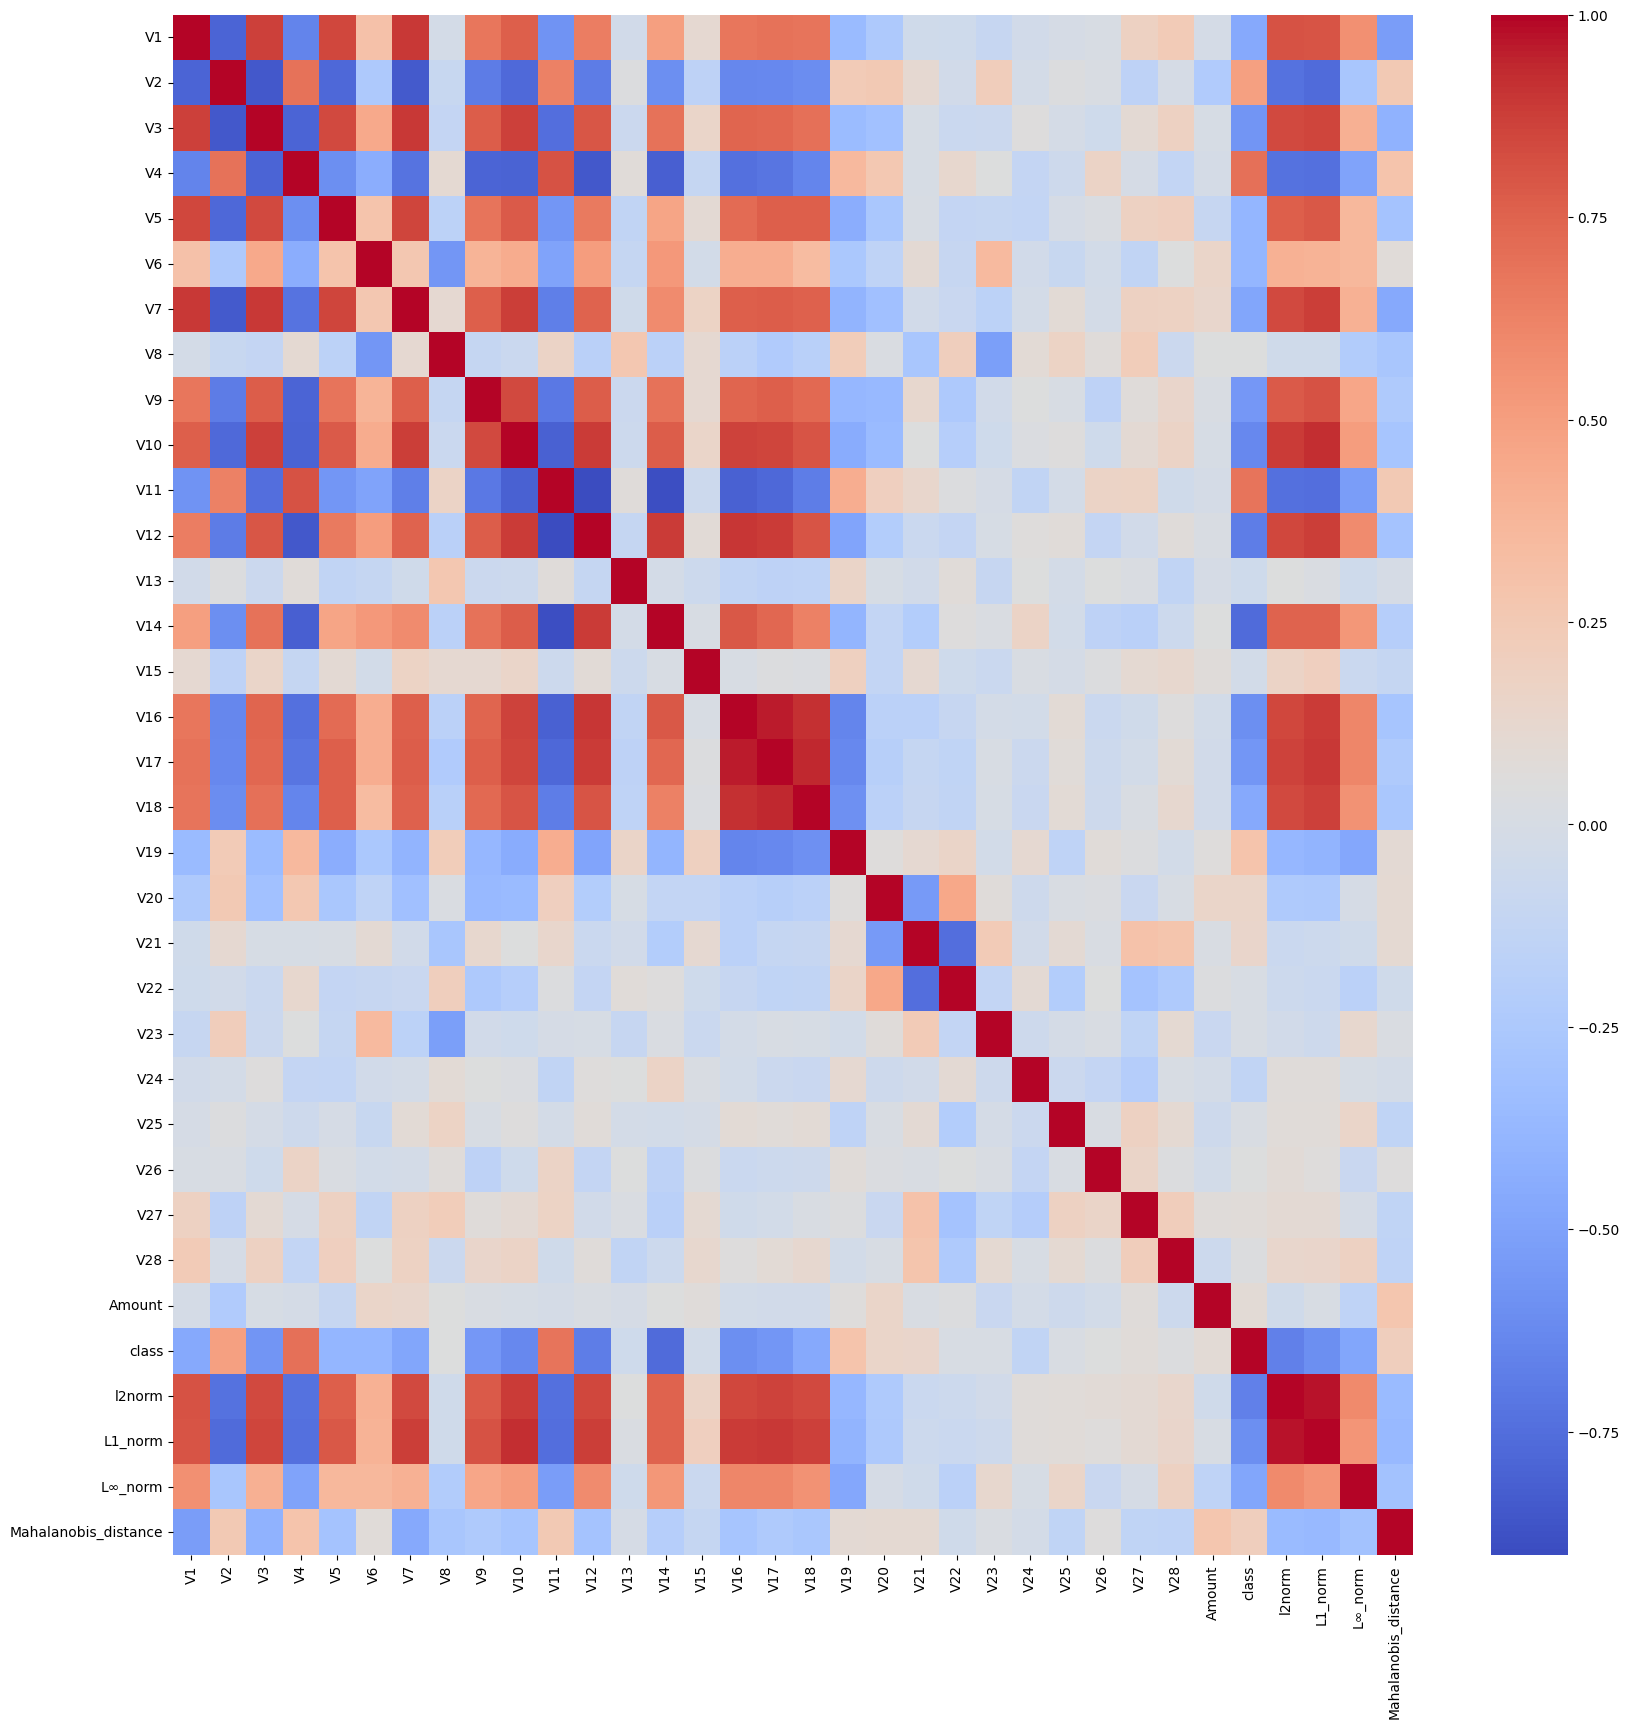

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

## isolation forests

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score

# Assuming df is your DataFrame and y_true is a Series or array containing the true class labels

# Create the Isolation Forest object
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01),
                      max_features=1.0, random_state=42)

# Fit the data and tag outliers
clf.fit(df)

# Get the predictions (-1 for outliers, 1 for inliers)
y_pred = clf.predict(df)

# Convert predictions to match y_true labeling (0: normal, 1: anomaly)
y_pred_adjusted = np.where(y_pred == 1, 0, 1)  # Converts -1 to 1 for anomalies, and 1 to 0 for normal

# Count the number of outliers
outlier_count = np.sum(y_pred_adjusted == 1)
print("Number of outliers:", outlier_count)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of outliers: 2849


In [14]:
import numpy as np

# Assuming y_pred_adjusted is longer than y_true
difference = len(y_pred_adjusted) - len(y_true)
if difference > 0:
    # Pad y_true with a specific value, e.g., 0 for normal
    y_true_padded = np.pad(y_true, (0, difference), 'constant', constant_values=(0,))
else:
    y_true_padded = y_true

# Now y_true_padded should have the same number of samples as y_pred_adjusted
# You can now generate the classification report and calculate AUC-ROC
print(classification_report(y_true_padded, y_pred_adjusted))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_true_padded, y_pred_adjusted)
print(f"AUC-ROC: {auc_roc}")


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    283823
           1       0.00      0.00      0.00       984

    accuracy                           0.99    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       0.99      0.99      0.99    284807

AUC-ROC: 0.4965107021354686


## Local Outlier Factor

In [15]:
from sklearn.neighbors import LocalOutlierFactor

# Create the LOF object
clf = LocalOutlierFactor(n_neighbors=20, contamination=float(0.01))

# Fit the data and tag the outliers
y_pred = clf.fit_predict(df)

# Reshape the predictions to a 1D array
y_pred = y_pred.reshape(-1,1)

# Print the number of outliers
print("Number of outliers:", len(df[y_pred == -1]))

Number of outliers: 2849


In [17]:
y_pred_adjusted = np.where(y_pred == 1, 0, 1) 
# Assuming y_pred_adjusted is longer than y_true
difference = len(y_pred_adjusted) - len(y_true)
if difference > 0:
    # Pad y_true with a specific value, e.g., 0 for normal
    y_true_padded = np.pad(y_true, (0, difference), 'constant', constant_values=(0,))
else:
    y_true_padded = y_true

# Now y_true_padded should have the same number of samples as y_pred_adjusted
# You can now generate the classification report and calculate AUC-ROC
print(classification_report(y_true_padded, y_pred_adjusted))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_true_padded, y_pred_adjusted)
print(f"AUC-ROC: {auc_roc}")

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    283823
           1       0.00      0.01      0.01       984

    accuracy                           0.99    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       0.99      0.99      0.99    284807

AUC-ROC: 0.5021195113042656


## One-class SVM

In [18]:
from sklearn.svm import OneClassSVM

# Create the One-class SVM object
clf = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.01)

# Fit the data and tag the outliers
clf.fit(df)

# Get the predictions
y_pred = clf.predict(df)

# Reshape the predictions to a 1D array
y_pred = y_pred.reshape(-1,1)

# Print the number of outliers
print("Number of outliers:", len(df[y_pred == -1]))

Number of outliers: 2843


In [19]:
y_pred_adjusted = np.where(y_pred == 1, 0, 1) 
# Assuming y_pred_adjusted is longer than y_true
difference = len(y_pred_adjusted) - len(y_true)
if difference > 0:
    # Pad y_true with a specific value, e.g., 0 for normal
    y_true_padded = np.pad(y_true, (0, difference), 'constant', constant_values=(0,))
else:
    y_true_padded = y_true

# Now y_true_padded should have the same number of samples as y_pred_adjusted
# You can now generate the classification report and calculate AUC-ROC
print(classification_report(y_true_padded, y_pred_adjusted))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_true_padded, y_pred_adjusted)
print(f"AUC-ROC: {auc_roc}")

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    283823
           1       0.00      0.01      0.00       984

    accuracy                           0.99    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       0.99      0.99      0.99    284807

AUC-ROC: 0.49958062255907854


## GridSearchCV

In [20]:
from sklearn.model_selection import train_test_split


# Define X and y
X = df.drop('class', axis=1)
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Create a list of classifiers to evaluate
classifiers = [LogisticRegression(), DecisionTreeClassifier(),RandomForestClassifier()]

# Create parameter grids for each classifier
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7]}
rf_params = {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7]}
knn_params = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
param_grids = [lr_params, dt_params, rf_params, knn_params]

# Loop over classifiers and parameter grids to find the best model
for i, classifier in enumerate(classifiers):
    clf = GridSearchCV(classifier, param_grids[i], cv=5)
    clf.fit(X_train, y_train)
    print(classifier.__class__.__name__)
    print(clf.best_params_)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

LogisticRegression
{'C': 10, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.60      0.70       136

    accuracy                           1.00     85443
   macro avg       0.93      0.80      0.85     85443
weighted avg       1.00      1.00      1.00     85443

DecisionTreeClassifier
{'criterion': 'gini', 'max_depth': 7}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.87      0.81      0.84       136

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443

RandomForestClassifier
{'max_depth': 7, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.78      0.86       136

    accuracy  

In [ ]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
# make predictions on the test set
y_pred = rf_model.predict(X_test)

# evaluate the model's performance
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_true_padded, y_pred_adjusted)


# print the classification metrics
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

In [ ]:
from sklearn.externals import joblib

# Define the file path to save the model
model_filename = 'vector_norm_anomaly_detection_random_forest_model.pkl'

# Save the trained model to disk
joblib.dump(rf_model, model_filename)

print("Model saved as", model_filename)